In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import glob
import scipy
import pdb
from tqdm import tqdm
import pickle
import sys
from matplotlib import pyplot as plt
import h5py

import networkx as nx
import igraph
import leidenalg

In [3]:
import sys

In [4]:
sys.path.append('/home/akumar/nse/neural_control')

In [5]:
from loaders import load_sabes_wf, load_sabes

In [6]:
import umap

/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
data_files = glob.glob('/mnt/Secondary/data/sabes/*.mat')

In [12]:
# Extract the spike width and hyperpolarization
def extract_wf_features(spike):

    # Global minima
    gmin = np.argmin(spike)

    # FWHM of the depression
    fwhm = scipy.signal.peak_widths(-1*spike, [gmin])
    fwhm = fwhm[3] - fwhm[2]
    fwhm = fwhm[0]
    # local maxima
    pks = scipy.signal.find_peaks(spike, height=0, prominence=0.2)[0]

    # After the minimum
    pks = pks[pks > gmin]

    # But before too long...
    pks = pks[t2[pks] - t2[gmin] < 25]

    # Normalize
    if len(pks) == 0:
        return np.nan, np.nan, np.nan, np.nan
    else:
        # Prominence of the hyperpolarization peak above baseline
        baseline = np.mean(spike[0:500])
        hyp_height = spike[pks[0]] - baseline     

        # Using the averaged traces, the post peak inflection point may be measurable
        # Use just the first derivative to reduce numerical noise
        ds = np.diff(spike)
        ds = np.abs(ds)/np.max(np.abs(ds))
        
        dpks = scipy.signal.find_peaks(np.abs(ds)/np.max(np.abs(ds)), height=0.05)[0]
        if len(dpks > 0):
            dpks = dpks[dpks > pks[0]]
            if len(dpks > 0):
                return fwhm, pks[0] - gmin, dpks[0] - pks[0], hyp_height
            else:
                return np.nan, np.nan, np.nan, np.nan   
        else:
            return np.nan, np.nan, np.nan, np.nan

In [9]:
# Exclude loco sessions that we don't use
valid_loco_fls = ['loco_20170210_03.mat',
 'loco_20170213_02.mat',
 'loco_20170215_02.mat',
 'loco_20170227_04.mat',
 'loco_20170228_02.mat',
 'loco_20170301_05.mat',
 'loco_20170302_02.mat',
 'indy_20160426_01.mat']


In [14]:
data_files = [f if 'loco' in f and f.split('/')[-1] in valid_loco_fls else f for f in data_files]

In [18]:
wf_len = []
for i, data_file in tqdm(enumerate(data_files)):
    if 'loco' in data_file and data_file.split('/')[-1] not in valid_loco_fls:
        continue
    dat = load_sabes(data_file, region='M1', bin_width=50, spike_threshold=100, boxcox=None, high_pass=False, return_wf=True)
    wf = dat['wf'].squeeze()
    wf_len.append(wf[0][0].size)

38it [00:26,  1.41it/s]


In [19]:
long_data_files = np.array(data_files)[np.argwhere(np.array(wf_len) == 64).squeeze()]

In [20]:
len(long_data_files)

30

In [58]:
rl = []
avg_wfs = []
wf_len = []
for i, data_file in tqdm(enumerate(long_data_files)):
    dat = load_sabes(data_file, region='M1', bin_width=50, spike_threshold=100, boxcox=None, high_pass=False, return_wf=True)
    wf = dat['wf'].squeeze()
    wf_len.append(wf[0][0].size)
    for cell in wf:
        spikes = []
        for j, spike in enumerate(cell):
            # Upsample the spike
            t1 = np.arange(len(spike))
            t2 = np.linspace(0, t1[-1], t1.size * 49)
            # Normalize 
            spike /= np.max(np.abs(spike))
            sinterp = scipy.interpolate.CubicSpline(t1, spike)
            spike_ = sinterp(t2)
            spikes.append(spike_)

        spike = np.mean(spikes, axis=0)
        spike = scipy.signal.decimate(scipy.signal.decimate(spike, 7), 7)
        if not np.any(np.isnan(extract_wf_features(spike))):
            avg_wfs.append(spike)

avg_wfs = np.array(avg_wfs)

30it [37:48, 75.62s/it] 


In [59]:
avg_wfs.shape

(3610, 64)

In [ ]:
# Get valid wf ids (no nans in wf features), and outlier removed ids from prior computation in cell_classification

In [60]:
with open('avg_wfs_64.dat', 'wb') as f:
    f.write(pickle.dumps(avg_wfs))

In [61]:
mapper = umap.UMAP(n_neighbors=20, min_dist=0.1).fit(avg_wfs)

In [66]:
g = igraph.Graph.Adjacency(mapper.graph_.toarray())

In [67]:
partition = leidenalg.find_partition(g, leidenalg.ModularityVertexPartition)

In [62]:
G = nx.from_numpy_array(mapper.graph_.toarray())

In [27]:
import networkx.algorithms.community as nx_comm

In [64]:
len(nx_comm.louvain_communities(G, seed=123))

18

In [30]:
import umap.plot

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:>

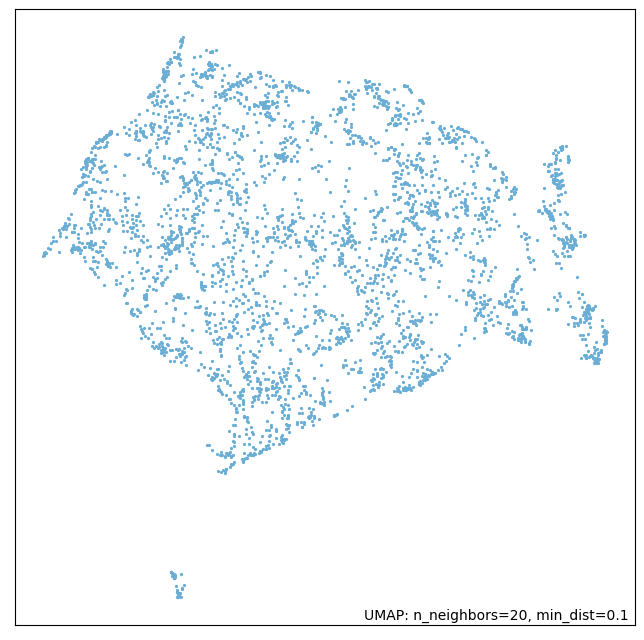

In [72]:
umap.plot.points(mapper)

In [73]:
# Try again on the shortended waveforms.

In [22]:
rl = []
avg_wfs48 = []
for i, data_file in tqdm(enumerate(data_files)):
    dat = load_sabes(data_file, region='M1', bin_width=50, spike_threshold=100, boxcox=None, high_pass=False, return_wf=True)
    wf = dat['wf'].squeeze()
    wf_len.append(wf[0][0].size)
    for cell in wf:
        spikes = []
        for j, spike in enumerate(cell):
            spike = spike[0:48]
            # Upsample the spike
            t1 = np.arange(len(spike))
            t2 = np.linspace(0, t1[-1], t1.size * 49)
            # Normalize 
            spike /= np.max(np.abs(spike))
            sinterp = scipy.interpolate.CubicSpline(t1, spike)
            spike_ = sinterp(t2)
            spikes.append(spike_)

        spike = np.mean(spikes, axis=0)
        spike = scipy.signal.decimate(scipy.signal.decimate(spike, 7), 7)
        if not np.any(np.isnan(extract_wf_features(spike))):
            avg_wfs48.append(spike)


38it [1:02:02, 97.96s/it] 


NameError: name 'avg_wfs' is not defined

In [23]:
avg_wfs48 = np.array(avg_wfs48)

In [36]:
mapper = umap.UMAP(n_neighbors=100, min_dist=1).fit(avg_wfs48)

In [37]:
G = nx.from_numpy_array(mapper.graph_.toarray())
len(nx_comm.louvain_communities(G, seed=123))

12

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:>

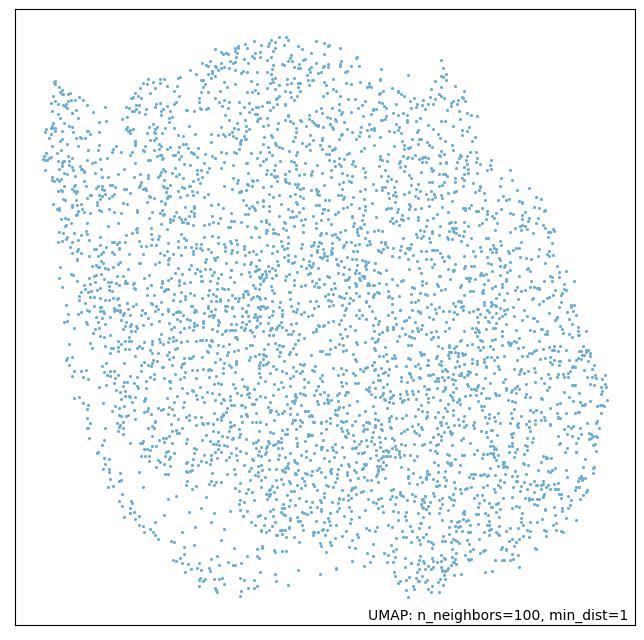

In [38]:
umap.plot.points(mapper)